# Dynamic regimes {#sec-dynamicregimes}

This section illustrates that different dynamic regimes with complex transient dynamics can emerge in CRLD. Dynamic regimes are, for example, the convergence to fixed points, continued oscillations, such as limit cycles or periodic orbits, and unpredictable, chaotic dynamics. Thus, they hold the potential for rich, dynamic phenomena beyond the convergence to static equilibria.

First, we import everything we need:

In [1]:
#| echo: false
import matplotlib as mpl

In [2]:
#| echo: false
mpl.rcParams['figure.dpi'] = 180

In [3]:
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

from pyCRLD.Environments.SocialDilemma import SocialDilemma as PD
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded as he
from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Utils import FlowPlot as fp

## Memory-one prisoners' dilemma environment
By trial and error, we saw that the ecological public goods environment is not prone to exhibit dynamic regimes other than convergence to fixed points. Thus, we here use the memory-one Prisoner's Dilemma. We start creating the memory-one Prisoner's Dilemma by initializing a standard normal-form Prisoner's Dilemma. 

In [4]:
pd = PD(R=1.0, T=1.25, S=-0.25, P=0)

The rewards of agent 1 and agent 2, respectively, are:

In [5]:
pd.R[0, 0, :, :, 0]

array([[ 1.  , -0.25],
       [ 1.25,  0.  ]])

and

In [6]:
pd.R[1, 0, :, :, 0]

array([[ 1.  ,  1.25],
       [-0.25,  0.  ]])

with the first action *cooperation*, and the second *defection*. The environment state set consists only of a void dummy state,

In [7]:
pd.Sset

['.']

To transform the normal-form Prisoner's Dilemma (PD) into a memory-one PD, we can use the history-embedding class `he`. 

In [10]:
#| hide
from nbdev.showdoc import *

In [11]:
show_doc(he)

---

[source](https://github.com/wbarfuss/pyCRLD/blob/main/pyCRLD/Environments/HistoryEmbedding.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### HistoryEmbedded

>      HistoryEmbedded (env, h)

Abstract Environment wrapper to embed a given environment into a larger
history space

`h` must be an iterable of length 1+N (where N=Nr. of Agents)
The first element of `history` specifies the length of the state-history.
Subsequent elements specify the length of the respective action-history

|    | **Details** |
| -- | ----------- |
| env | An environment |
| h | History specification |

Thus,

In [12]:
# Inititalize the memory-1 Prisoner's Dilemma:
env = he(pd, (1,1,1))

which automatically results in the following four environmental states,

In [13]:
env.Sset

['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']

For example, the first state, `'c,c,.|`, indicates that both agents chose cooperation `c` in the previous round. The state, `'c,d,.|`, means that the first agents chose cooperation `c` and the second defection `d`, and so on.

With the memory-one PD environment ready, we can finally create the multi-agent environment interface

In [14]:
MAEi = stratAC(env=env, learning_rates=0.1, discount_factors=0.99)

## Compute data
The initial strategy is vital to showcase different dynamic regimes in the memory-one PD environment. By trial and error (see @sec-findstrategy), we obtained an interesting initial strategy which we hardcoded below. We compare this initial strategy to two other strategies. One is close by, the other further apart.

In [15]:
# Initial strategies
# ------------------
# Initial strategy 1
X1 = np.array([[[0.60862106, 0.39137894],
                [0.65139908, 0.34860092],
                [0.72655916, 0.27344087],
                [0.52245504, 0.47754502]],
               [[0.26495466, 0.73504543],
                [0.88308924, 0.1169107 ],
                [0.37133005, 0.62866992],
                [0.53166837, 0.46833161]]])
# Initial strategy 2
X2 = np.array([[[0.60, 0.4],
                [0.6, 0.4],
                [0.7, 0.3],
                [0.5, 0.5]],
               [[0.3, 0.7],
                [0.8, 0.2 ],
                [0.3, 0.7],
                [0.5, 0.5]]])
# Initial strategy 3
Pi = np.array([0.98, 0.05, 0.85, 0.99])
Pj = np.array([0.2, 0.8, 0.05, 0.95])
xi = np.array([Pi, 1-Pi]).T
xj = np.array([Pj, 1-Pj]).T
X3 = np.array([xi, xj])
# Initial strategies
Xs = [X1, X2, X3]

# Trajectories
# ------------
xtrajs = []  # storing strategy trajectories 
fprs = []    # and whether a fixed point is reached
for i, X in enumerate(Xs):
    xtraj, fpr = MAEi.trajectory(X, Tmax=2500, tolerance=10**-5)
    xtrajs.append(xtraj)
    fprs.append(fpr)
    
# Compute reward trajectories   
rtrajs = [np.array([MAEi.Ri(x) for x in xtraj]) for xtraj in xtrajs]

## Plot data
We plot the computed data with the strategy trajectories in phase space and reward trajectories over time.

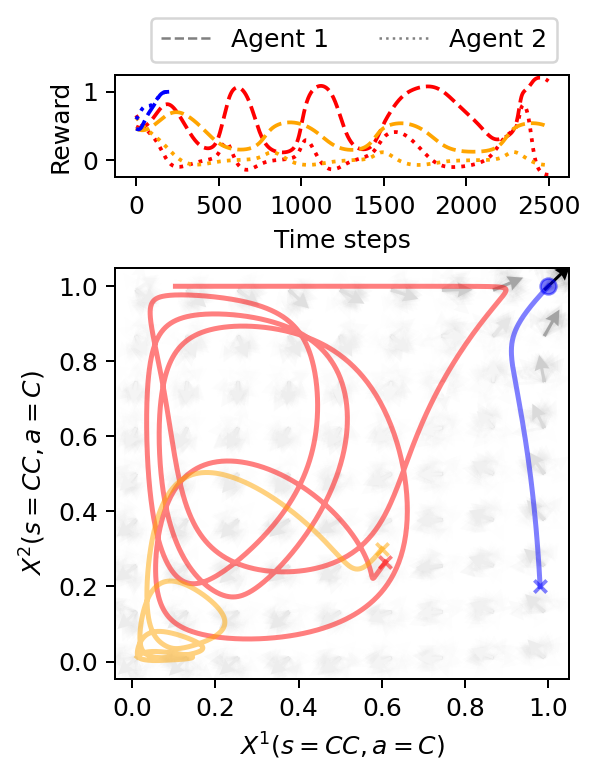

In [17]:
#| fig-cap: "Different dynamic regimes in the phase space of the memory-1 Prisoners' Dilemma"
# Create canvas
fsf = 0.7  # figure size factor
fig = plt.figure(figsize=(fsf*4.5, fsf*6))
gs = GridSpec(2, 1, height_ratios=[1, 4], 
              hspace=0.35, left=0.18, right=0.98, top=0.92, bottom=0.12)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Strategy flow plot
# ------------------
x = ([0], [0], [0])  # which (agent, observation, action) to plot on x axis
y = ([1], [0], [0])  # which (agent, observation, action) to plot on y axis
eps=10e-3; action_probability_points = np.linspace(0+eps, 1.0-eps, 9)
fp.plot_strategy_flow(MAEi, x, y, action_probability_points, NrRandom=64,
                      cmap='Greys', sf=0.20, axes=[ax2])

# Trajectories
# ------------
# in phase space
fp.plot_trajectories(xtrajs, x=x, y=y, fprs=fprs, axes=[ax2], alphas=[0.5],
                     cols=['red','orange','blue'], lws=[2], lss=['-'])
# and over time      
ax1.plot(rtrajs[0][:, 0], c='red', ls='--')
ax1.plot(rtrajs[0][:, 1], c='red', ls=':')
ax1.plot(rtrajs[1][:, 0], c='orange', ls='--')
ax1.plot(rtrajs[1][:, 1], c='orange', ls=':')
ax1.plot(rtrajs[2][:, 0], c='blue', ls='--')
ax1.plot(rtrajs[2][:, 1], c='blue', ls=':')

# Decorations
# -----------
# Make labels nice
ax1.set_ylim(-0.25, 1.25)
ax1.set_ylabel('Reward')
ax1.set_xlabel('Time steps')
ax2.set_ylabel(f"$X^2(s=CC,a=C)$")
ax2.set_xlabel(f"$X^1(s=CC,a=C)$")

# Create legend
custom_lines = [Line2D([0], [0], color='gray', ls='--', lw=1),
                Line2D([0], [0], color='gray', ls=':', lw=1)]
ax1.legend(custom_lines, ['Agent 1', 'Agent 2'], ncol=2, bbox_to_anchor=(1,1),
           loc='lower right')

# Save plot
plt.savefig('_figs/fig_04DynamicRegimes.png', dpi=150)

## Find initial strategy {#sec-findstrategy}
Last, we show how to find an initial strategy that leads to a dynamic regime other than the convergence to a fixed point. 

In [16]:
# If necessary, create  multi-agent environment interface from scratch
env = he(PD(R=1.0, T=1.25, S=-0.25, P=0), (1,1,1))
MAEi = stratAC(env=env, learning_rates=0.1, discount_factors=0.99)

# Compute trajectories for some random initial strategies
# and see whether they did not reach a fixed point.
print("No fixed point reached for trajectories:")
xtrajs = []
Tmax = 2500 # Convergence-time threshold 
for i in range(500):
    X = MAEi.random_softmax_strategy()
    xtraj, fpr = MAEi.trajectory(X, Tmax=Tmax, tolerance=10**-5)
    xtrajs.append(xtraj)
        
    if not fpr:
        print(i, end=' ')

No fixed point reached for trajectories:
142 238 487 

We check that the center of the distribution of convergence times is well below the convergence-time threshold.

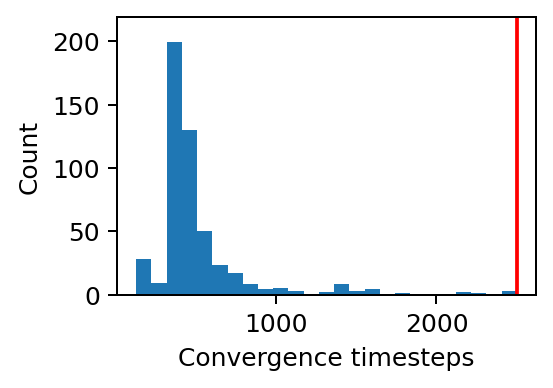

In [17]:
#| fig-cap: "Histogram of convergence times."
plt.figure(figsize=(3,2))
hist = plt.hist([len(xt) for xt in xtrajs], bins=25)
plt.plot([Tmax, Tmax], [0, 1.1*max(hist[0])], c='red')
plt.ylim(0, 1.1*max(hist[0]))
plt.xlabel("Convergence timesteps")   
plt.ylabel("Count");

Last, we examine the non-convergent trajectories in the strategy phase space of all environmental states of the memory-one Prisoner's Dilemma. 

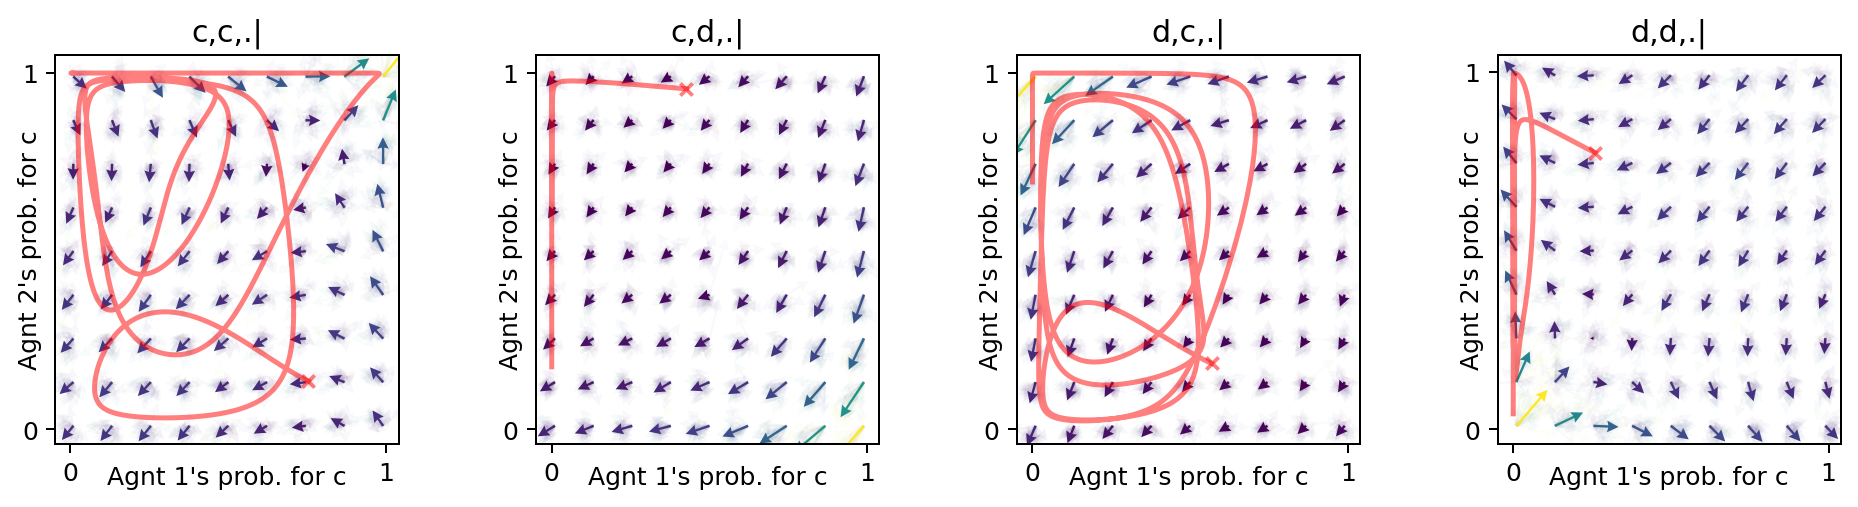

In [20]:
xt, fpr = MAEi.trajectory(xtrajs[238][0], Tmax=2500, tolerance=10**-5)

x = ([0], [0,1,2,3], [0])  # which (agent, observation, action) to plot on x ax
y = ([1], [0,1,2,3], [0])  # which (agent, observation, action) to plot on y ax
eps=10e-3; action_probability_points = np.linspace(0+eps, 1.0-eps, 9)
ax = fp.plot_strategy_flow(MAEi, x, y, action_probability_points, NrRandom=32,
                           conds=MAEi.env.Sset)
fp.plot_trajectories([xt], x=x, y=y, 
                     cols=['red'], lws=[2], lss=['-'], alphas=[0.5], axes=ax);